# Introduction

The goal of the project is to predict which country a new user's first booking destination will be. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. All the users in this dataset are from the USA.

# DATA

In [133]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
sns.set(style="whitegrid", context="talk")
pd.set_option('display.max_columns', None)

In [134]:
countries = pd.read_csv("/Users/soledadmusella/Desktop/data_capstone/countries.csv") 

In [135]:
 countries.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [136]:
age_gender = pd.read_csv("/Users/soledadmusella/Desktop/data_capstone/age_gender_bkts.csv") 

In [137]:
age_gender.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [138]:
age_gender.isnull().sum()

age_bucket                 0
country_destination        0
gender                     0
population_in_thousands    0
year                       0
dtype: int64

In [139]:
age_gender["gender"].value_counts()

male      210
female    210
Name: gender, dtype: int64

In [140]:
#I want to transform the categorical variable gender in to a binary variable 

In [141]:
age_gender.age_bucket.unique()

array(['100+', '95-99', '90-94', '85-89', '80-84', '75-79', '70-74',
       '65-69', '60-64', '55-59', '50-54', '45-49', '40-44', '35-39',
       '30-34', '25-29', '20-24', '15-19', '10-14', '5-9', '0-4'],
      dtype=object)

In [142]:
age_gender.age_bucket = age_gender.age_bucket.apply(lambda x: x[0] if x =="0-4" or x =="5-9" 
                                                    else (x[:3] if x == "100+" else x[:2])).astype(int)
age_gender.age_bucket.unique()

array([100,  95,  90,  85,  80,  75,  70,  65,  60,  55,  50,  45,  40,
        35,  30,  25,  20,  15,  10,   5,   0])

In [143]:
sessions = pd.read_csv("/Users/soledadmusella/Desktop/data_capstone/sessions.csv") 

In [144]:
sessions.head(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [145]:
sessions.action.value_counts()

show                           2768278
index                           843699
search_results                  725226
personalize                     706824
search                          536057
ajax_refresh_subtotal           487744
update                          365130
similar_listings                364624
social_connections              339000
reviews                         320591
active                          188036
similar_listings_v2             168788
lookup                          162041
create                          155887
dashboard                       152952
header_userpic                  141830
collections                     124417
edit                            109083
campaigns                       105028
track_page_view                  81117
unavailabilities                 78317
qt2                              64651
notifications                    59392
confirm_email                    58726
requested                        57034
identity                 

In [146]:
sessions.action_type.isna().sum()

1126204

In [147]:
sessions.action_detail.isna().sum()

1126204

In [148]:
sessions.loc[sessions["action"]=="lookup","action_type"]="lookup"

In [149]:
sessions.loc[sessions["action"]=="lookup","action_detail"]="lookup"

In [150]:
sessions["device_type"].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [151]:
sessions["action"].value_counts().head()

show              2768278
index              843699
search_results     725226
personalize        706824
search             536057
Name: action, dtype: int64

## Users

In [152]:
users = pd.read_csv("/Users/soledadmusella/Desktop/data_capstone/train_users.csv") 


In [153]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [154]:
users["country_destination"].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [155]:
users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [156]:
# date_first_booking can be fine couse those are likely to be the users who did not book a trip anywhere

In [157]:
users["age"].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [158]:
# I trasform the outliers in the column age

In [159]:
users.loc[users["age"]< 10, "age"] = 10
users.loc[users['age'] > 100, "age"] = 100

In [160]:
users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [161]:
# I swap the null values in the column age with the mean of the age 

In [162]:
users["age"] = users["age"].fillna(value=users["age"].mean())
users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                             0
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## EDA

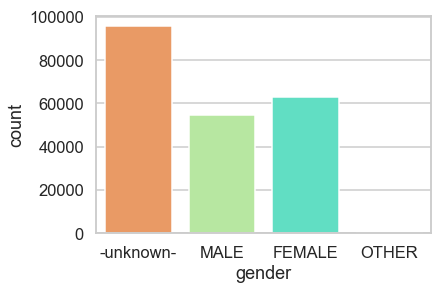

In [163]:
sns.countplot(users['gender'], palette = "rainbow_r")

Look for a trend in the dataset regarding the destinations choeesen by gender

In [164]:
female = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts().sum()
male = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts().sum()

In [165]:
female_destination = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / female*100
male_destionation = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / male*100

In [166]:

female_destination

NDF      49.250488
US       35.998794
other     5.012611
FR        3.112260
IT        1.730620
GB        1.397503
ES        1.353088
CA        0.721753
DE        0.567884
NL        0.402912
AU        0.328358
PT        0.123729
Name: country_destination, dtype: float64

In [167]:
male_destination = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / male * 100

In [168]:
male_destination

NDF      49.079721
US       35.740265
other     6.324394
FR        2.452241
IT        1.283982
GB        1.252755
ES        1.243571
CA        0.876194
DE        0.764144
NL        0.510654
AU        0.345334
PT        0.126745
Name: country_destination, dtype: float64

In [169]:
male_female_destination = pd.concat([female_destination,male_destination], axis =1)
male_female_destination.columns = ["female_destination","male_destination"]

In [170]:
male_female_destination

,female_destination,male_destination
NDF,49.250488,49.079721
US,35.998794,35.740265
other,5.012611,6.324394
FR,3.112260,2.452241
IT,1.730620,1.283982
GB,1.397503,1.252755
ES,1.353088,1.243571
CA,0.721753,0.876194
DE,0.567884,0.764144
NL,0.402912,0.510654


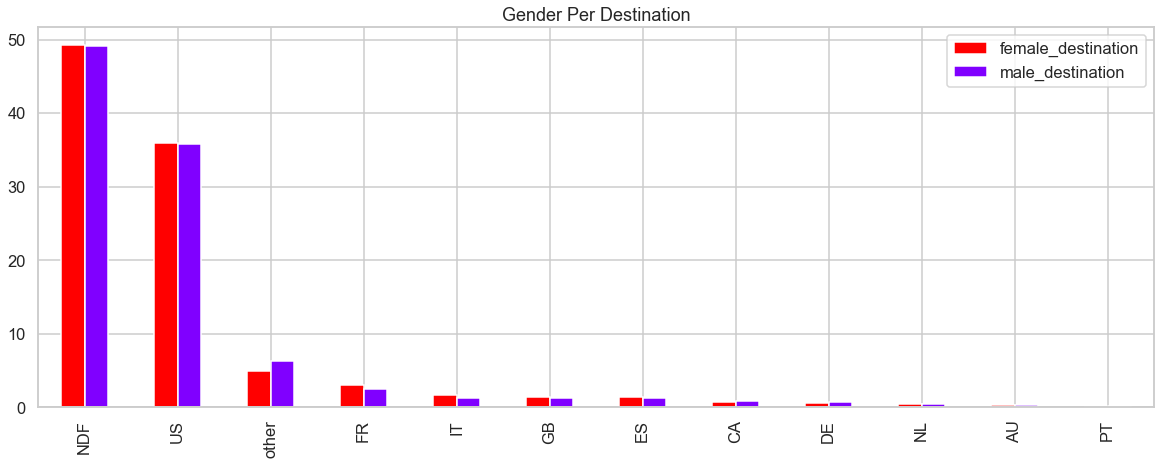

In [171]:
ax = male_female_destination.plot.bar(colormap = 'rainbow_r', title = 'Gender Per Destination',figsize = (20, 7))


In [172]:
users["signup_method"].value_counts()

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

Visualization to see if there is significative trend between the categorical variable "signup_method" and the country of destination

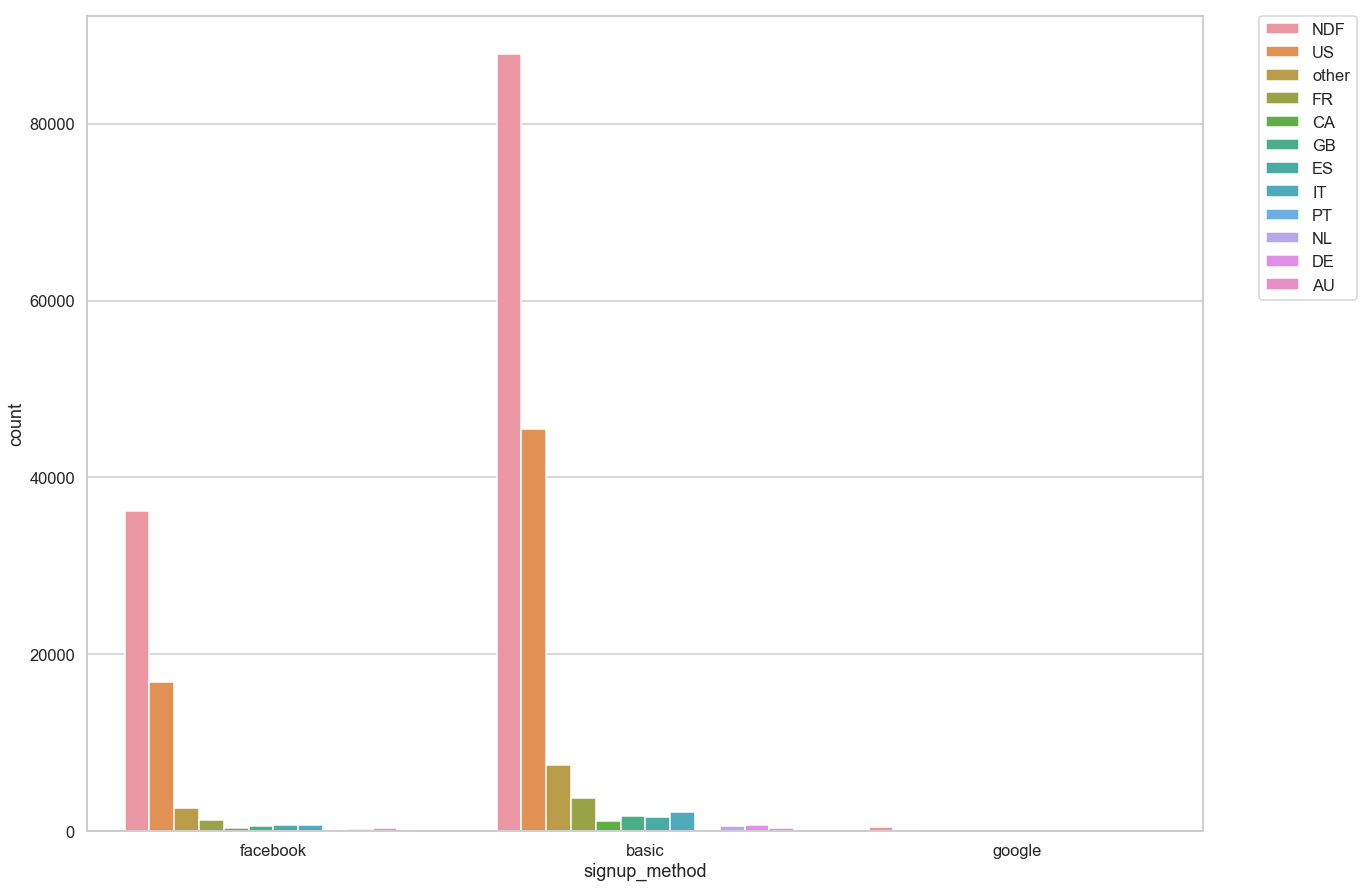

In [173]:
plt.figure(figsize=(20,15))
sns.countplot(users['signup_method'], hue=users['country_destination'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


In [174]:
users["first_device_type"].value_counts()

Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

Visualization to see if there is a trend between the categorical variable "first_device_type" and the country of destination

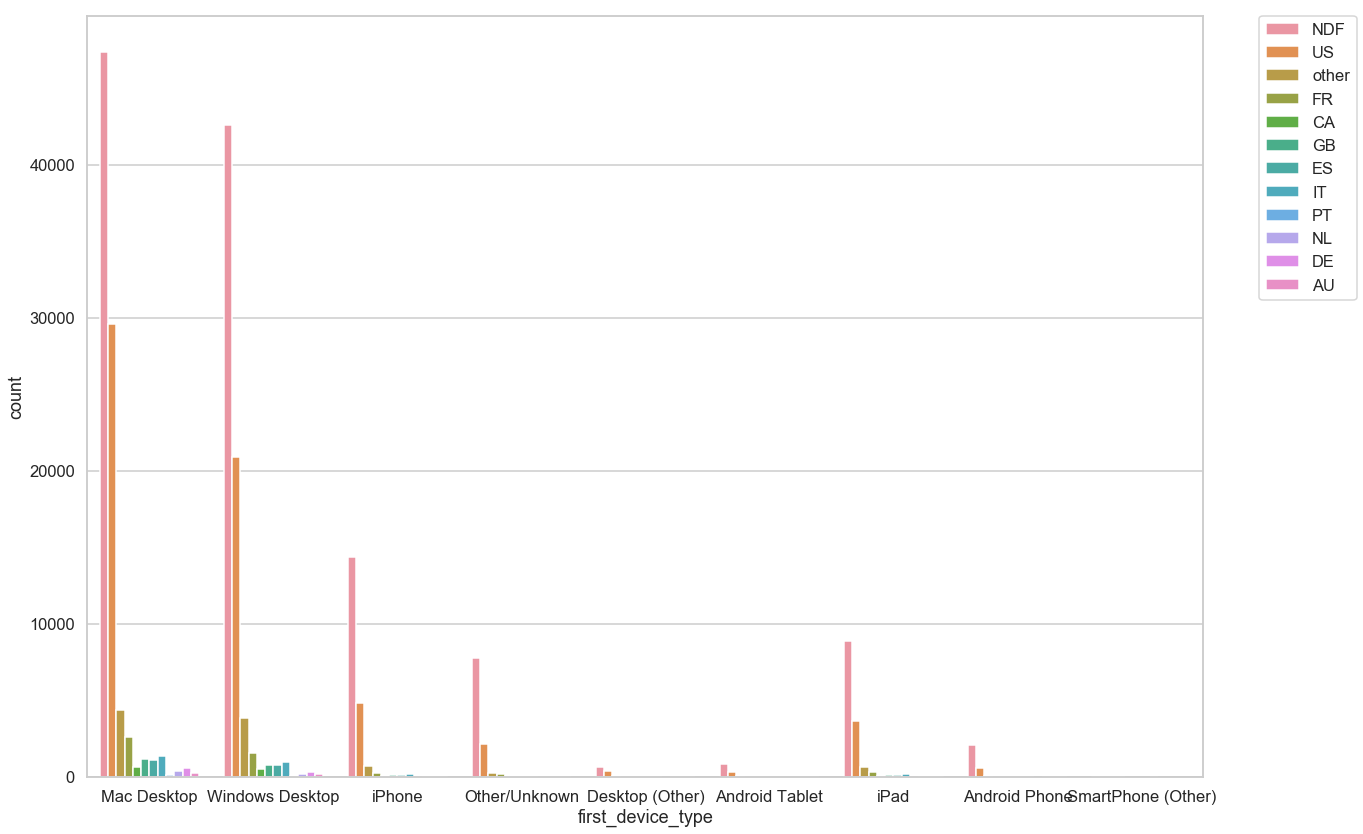

In [175]:
plt.figure(figsize=(20,14))
sns.countplot(users['first_device_type'], hue=users['country_destination'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


## Feature Engeneering

##### Sessions

In [176]:
sessions.shape

(10567737, 6)

#### First action

In [177]:
first_action = sessions.groupby(['user_id'])['action'].first().reset_index()
first_action_type = sessions.groupby(['user_id'])['action_type'].first().reset_index()
first_action_detail = sessions.groupby(['user_id'])['action_detail'].first().reset_index()
# We don't need to get the first device type because that info is already on the users data

In [178]:
first_action_detail.isnull().sum()

user_id          0
action_detail    5
dtype: int64

In [179]:
first_action.isna().sum()

user_id      0
action     440
dtype: int64

In [180]:
first_action_type.isna().sum()

user_id        0
action_type    5
dtype: int64

In [181]:
first_0 = pd.merge(first_action, first_action_type, how='outer', on='user_id')
extra_data_0 = pd.merge(first_0, first_action_detail, how='outer', on='user_id')
extra_data_0.columns = ['id', 'first_action', 'first_action_type', 'first_action_detail']
extra_data_0.head()

,id,first_action,first_action_type,first_action_detail
0,00023iyk9l,index,view,view_search_results
1,0010k6l0om,search_results,click,view_search_results
2,001wyh0pz8,search,click,view_search_results
3,0028jgx1x1,show,view,user_profile
4,002qnbzfs5,social_connections,data,user_social_connections


#### Last action

In [182]:
last_action = sessions.groupby(['user_id'])['action'].last().reset_index()
last_action_type = sessions.groupby(['user_id'])['action_type'].last().reset_index()
last_action_detail = sessions.groupby(['user_id'])['action_detail'].last().reset_index()
last_device_type = sessions.groupby(['user_id'])['device_type'].last().reset_index()


In [183]:
last_device_type.isnull().sum()

user_id        0
device_type    0
dtype: int64

In [184]:
extra_data_10 = pd.merge(extra_data_0, last_action, how='outer', left_on='id', right_on='user_id')
extra_data_1 = pd.merge(extra_data_10, last_action_type, how='outer', on='user_id')
extra_data_2 = pd.merge(extra_data_1, last_action_detail, how='outer', on='user_id')
extra_data_3 = pd.merge(extra_data_2, last_device_type, how='outer', on='user_id')
extra_data_3.columns = ['id', 'first_action', 'first_action_type', 'first_action_detail','user_id',
                        'last_action', 'last_action_type', 'last_action_detail','last_device_type']
extra_data_3.head()

,id,first_action,first_action_type,first_action_detail,user_id,last_action,last_action_type,last_action_detail,last_device_type
0,00023iyk9l,index,view,view_search_results,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop
1,0010k6l0om,search_results,click,view_search_results,0010k6l0om,search_results,click,view_search_results,Mac Desktop
2,001wyh0pz8,search,click,view_search_results,001wyh0pz8,search,click,view_search_results,Android App Unknown Phone/Tablet
3,0028jgx1x1,show,view,user_profile,0028jgx1x1,search,click,view_search_results,-unknown-
4,002qnbzfs5,social_connections,data,user_social_connections,002qnbzfs5,social_connections,data,user_social_connections,iPhone


#### Number of Actions

In [185]:
size_actions = sessions.groupby(['user_id']).size().reset_index()

In [186]:
extra_data_4 = pd.merge(extra_data_3, size_actions, how='outer', on='user_id')
extra_data_4.columns = ['id', 'first_action', 'first_action_type', 'first_action_detail','user_id',
                        'last_action', 'last_action_type', 'last_action_detail','last_device_type',
                        '#actions']
extra_data_4.head()

,id,first_action,first_action_type,first_action_detail,user_id,last_action,last_action_type,last_action_detail,last_device_type,#actions
0,00023iyk9l,index,view,view_search_results,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,40
1,0010k6l0om,search_results,click,view_search_results,0010k6l0om,search_results,click,view_search_results,Mac Desktop,63
2,001wyh0pz8,search,click,view_search_results,001wyh0pz8,search,click,view_search_results,Android App Unknown Phone/Tablet,90
3,0028jgx1x1,show,view,user_profile,0028jgx1x1,search,click,view_search_results,-unknown-,31
4,002qnbzfs5,social_connections,data,user_social_connections,002qnbzfs5,social_connections,data,user_social_connections,iPhone,789


#### Nunique

In [187]:
nunique_action = sessions.groupby(['user_id'])['action'].nunique().reset_index()
nunique_action_type = sessions.groupby(['user_id'])['action_type'].nunique().reset_index()
nunique_action_detail = sessions.groupby(['user_id'])['action_detail'].nunique().reset_index()
nunique_device_type = sessions.groupby(['user_id'])['device_type'].nunique().reset_index()

In [188]:
extra_data_5 = pd.merge(extra_data_4, nunique_action, how='outer', on='user_id')
extra_data_6 = pd.merge(extra_data_5, nunique_action_type, how='outer', on='user_id')
extra_data_7 = pd.merge(extra_data_6, nunique_action_detail, how='outer', on='user_id')
extra_data_8 = pd.merge(extra_data_7, nunique_device_type, how='outer', on='user_id')
extra_data_8.drop(['user_id'], inplace=True, axis=1)
extra_data_8.columns = ['id', 'first_action', 'first_action_type', 'first_action_detail',
                        'last_action', 'last_action_type', 'last_action_detail','last_device_type',
                        '#actions',
                        'nunique_action', 'nunique_action_type', 'nunique_action_detail','nunique_device_type']
extra_data_8.head()

,id,first_action,first_action_type,first_action_detail,last_action,last_action_type,last_action_detail,last_device_type,#actions,nunique_action,nunique_action_type,nunique_action_detail,nunique_device_type
0,00023iyk9l,index,view,view_search_results,personalize,data,wishlist_content_update,Mac Desktop,40,13,6,13,2
1,0010k6l0om,search_results,click,view_search_results,search_results,click,view_search_results,Mac Desktop,63,11,5,8,1
2,001wyh0pz8,search,click,view_search_results,search,click,view_search_results,Android App Unknown Phone/Tablet,90,10,5,9,1
3,0028jgx1x1,show,view,user_profile,search,click,view_search_results,-unknown-,31,5,5,6,2
4,002qnbzfs5,social_connections,data,user_social_connections,social_connections,data,user_social_connections,iPhone,789,25,7,22,2


### Users

In [192]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,days_before_first_booking
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,-unknown-,37.732921,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38.000000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,NaN
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.000000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,-57.0
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.000000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,278.0
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,-208.0


#### Days Between Sign Up and First Booking

In [193]:
users['date_account_created'] = pd.to_datetime(users.date_account_created)
users['date_first_booking'] = pd.to_datetime(users.date_first_booking)

In [194]:
users['days_before_first_booking'] = (users['date_first_booking'] - users['date_account_created']).dt.days 

### Merge

In [195]:
users.shape

(213451, 17)

In [196]:
extra_data_8.shape

(135483, 13)

In [197]:
users.id.nunique()

213451

In [198]:
final_users = pd.merge(users, extra_data_8, how='inner', on='id')
final_users.head()


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,days_before_first_booking,first_action,first_action_type,first_action_detail,last_action,last_action_type,last_action_detail,last_device_type,#actions,nunique_action,nunique_action_type,nunique_action_detail,nunique_device_type
0,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.000000,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,3.0,lookup,lookup,lookup,show,view,p3,Windows Desktop,127,16,7,10,2
1,yo8nz8bqcq,2014-01-01,20140101001558,NaT,-unknown-,37.732921,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,NaN,dashboard,view,dashboard,show,data,wishlist_content_update,Mac Desktop,9,7,4,8,1
2,4grx6yxeby,2014-01-01,20140101001639,NaT,-unknown-,37.732921,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,NaN,verify,-unknown-,-unknown-,personalize,data,wishlist_content_update,Windows Desktop,16,12,6,8,2
3,ncf87guaf0,2014-01-01,20140101002146,NaT,-unknown-,37.732921,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,NaN,lookup,lookup,lookup,personalize,data,wishlist_content_update,Windows Desktop,152,19,6,12,3
4,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,37.732921,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,1.0,campaigns,-unknown-,-unknown-,index,-unknown-,-unknown-,iPhone,8,7,1,1,1


In [199]:
final_users.tail()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,days_before_first_booking,first_action,first_action_type,first_action_detail,last_action,last_action_type,last_action_detail,last_device_type,#actions,nunique_action,nunique_action_type,nunique_action_detail,nunique_device_type
73810,zxodksqpep,2014-06-30,20140630235636,NaT,MALE,32.000000,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,NaN,edit,view,edit_profile,edit,view,edit_profile,Mac Desktop,110,37,7,24,2
73811,mhewnxesx9,2014-06-30,20140630235719,NaT,-unknown-,37.732921,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,NaN,confirm_email,click,confirm_email_link,personalize,data,wishlist_content_update,Windows Desktop,238,24,7,22,3
73812,6o3arsjbb4,2014-06-30,20140630235754,NaT,-unknown-,32.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,NaN,ajax_refresh_subtotal,click,change_trip_characteristics,show,view,p3,Mac Desktop,18,10,4,10,1
73813,jh95kwisub,2014-06-30,20140630235822,NaT,-unknown-,37.732921,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,NaN,search,click,view_search_results,search,click,view_search_results,iPhone,75,8,5,8,1
73814,nw9fwlyb5f,2014-06-30,20140630235824,NaT,-unknown-,37.732921,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,NaN,show,view,user_profile,search,click,view_search_results,iPhone,41,13,5,12,1


In [200]:
final_users.isna().sum()

id                               0
date_account_created             0
timestamp_first_active           0
date_first_booking           45041
gender                           0
age                              0
signup_method                    0
signup_flow                      0
language                         0
affiliate_channel                0
affiliate_provider               0
first_affiliate_tracked        302
signup_app                       0
first_device_type                0
first_browser                    0
country_destination              0
days_before_first_booking    45041
first_action                   409
first_action_type                3
first_action_detail              3
last_action                    409
last_action_type                 3
last_action_detail               3
last_device_type                 0
#actions                         0
nunique_action                   0
nunique_action_type              0
nunique_action_detail            0
nunique_device_type 

## DATA CLEANING and DATA INSPECTION

I will perfrom data cleaning on my "final_users" dataset, which is the final dataset that I will use to perform my analisys.
This dataset is the result of the merge of the initial data set "users" and the new columns that I've created by feature engeeniering few columns of the "sessions" data set.

In [202]:
final_users["signup_flow"].value_counts() # the signup flow is the page a user come to signup from.

0     57088
25     8344
12     3942
23     2162
24     2160
8       116
21        3
Name: signup_flow, dtype: int64

In [203]:
final_users["affiliate_channel"].value_counts() #what kind of paid marketing

direct           46814
sem-brand        12586
sem-non-brand     5140
seo               3327
api               2784
content           1631
other              843
remarketing        690
Name: affiliate_channel, dtype: int64

In [204]:
final_users["affiliate_provider"].value_counts() #where the marketing is

direct                 46814
google                 21604
other                   3315
bing                     862
facebook                 664
padmapper                166
email-marketing           93
yahoo                     92
facebook-open-graph       89
gsp                       32
vast                      29
naver                     19
yandex                    13
baidu                     13
meetup                     7
craigslist                 2
daum                       1
Name: affiliate_provider, dtype: int64

In [205]:
final_users["first_affiliate_tracked"].value_counts() #whats the first marketing the user interacted with before the signing up

untracked        39049
omg              18342
linked           14316
tracked-other      938
product            733
marketing          110
local ops           25
Name: first_affiliate_tracked, dtype: int64

In [206]:
final_users["signup_app"].value_counts()

Web        57016
iOS        10410
Android     3779
Moweb       2610
Name: signup_app, dtype: int64

In [207]:
final_users["first_device_type"].value_counts()

Mac Desktop           28029
Windows Desktop       23395
iPhone                10961
iPad                   5238
Other/Unknown          2993
Android Phone          1979
Android Tablet          701
Desktop (Other)         489
SmartPhone (Other)       30
Name: first_device_type, dtype: int64

Using the isnull() function I can see that most of the features have nulls values. I will inspect each by each and I will take action on the nulls values.  

In [208]:
final_users.isnull().sum()

id                               0
date_account_created             0
timestamp_first_active           0
date_first_booking           45041
gender                           0
age                              0
signup_method                    0
signup_flow                      0
language                         0
affiliate_channel                0
affiliate_provider               0
first_affiliate_tracked        302
signup_app                       0
first_device_type                0
first_browser                    0
country_destination              0
days_before_first_booking    45041
first_action                   409
first_action_type                3
first_action_detail              3
last_action                    409
last_action_type                 3
last_action_detail               3
last_device_type                 0
#actions                         0
nunique_action                   0
nunique_action_type              0
nunique_action_detail            0
nunique_device_type 

In [212]:
100*final_users["date_first_booking"].isna().sum()/len(final_users)

61.01876312402628

In [213]:
100*final_users["days_before_first_booking"].isna().sum()/len(final_users)

61.01876312402628

I can clearly see that the features "date_first_booking" and "days_before_first_booking" have more than the 60% of null values so i decide to drop thoose columns from the data frame final_users

In [214]:
final_users.drop(['date_first_booking',"days_before_first_booking"],axis=1, inplace=True)


In [215]:
final_users.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_action,first_action_type,first_action_detail,last_action,last_action_type,last_action_detail,last_device_type,#actions,nunique_action,nunique_action_type,nunique_action_detail,nunique_device_type
0,d1mm9tcy42,2014-01-01,20140101000936,MALE,62.000000,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,lookup,lookup,lookup,show,view,p3,Windows Desktop,127,16,7,10,2
1,yo8nz8bqcq,2014-01-01,20140101001558,-unknown-,37.732921,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,dashboard,view,dashboard,show,data,wishlist_content_update,Mac Desktop,9,7,4,8,1
2,4grx6yxeby,2014-01-01,20140101001639,-unknown-,37.732921,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,verify,-unknown-,-unknown-,personalize,data,wishlist_content_update,Windows Desktop,16,12,6,8,2
3,ncf87guaf0,2014-01-01,20140101002146,-unknown-,37.732921,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,lookup,lookup,lookup,personalize,data,wishlist_content_update,Windows Desktop,152,19,6,12,3
4,4rvqpxoh3h,2014-01-01,20140101002619,-unknown-,37.732921,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,campaigns,-unknown-,-unknown-,index,-unknown-,-unknown-,iPhone,8,7,1,1,1


# Baseline Model


## Logistic regression

My project has to deal with a multiclass classification problem so I decide to run as a baseline model a simple logistic regression.


In [216]:
final_users.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'first_action', 'first_action_type', 'first_action_detail',
       'last_action', 'last_action_type', 'last_action_detail',
       'last_device_type', '#actions', 'nunique_action', 'nunique_action_type',
       'nunique_action_detail', 'nunique_device_type'],
      dtype='object')

In [222]:
users_dummies = pd.get_dummies(final_users[['gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'first_action', 'first_action_type', 'first_action_detail',
       'last_action', 'last_action_type', 'last_action_detail',
       'last_device_type', '#actions', 'nunique_action', 'nunique_action_type',
       'nunique_action_detail', 'nunique_device_type']],drop_first=True)
print(users_dummies.columns)
users_dummies.shape

Index(['age', 'signup_flow', '#actions', 'nunique_action',
       'nunique_action_type', 'nunique_action_detail', 'nunique_device_type',
       'gender_FEMALE', 'gender_MALE', 'gender_OTHER',
       ...
       'last_device_type_Blackberry', 'last_device_type_Chromebook',
       'last_device_type_Linux Desktop', 'last_device_type_Mac Desktop',
       'last_device_type_Tablet', 'last_device_type_Windows Desktop',
       'last_device_type_Windows Phone', 'last_device_type_iPad Tablet',
       'last_device_type_iPhone', 'last_device_type_iPodtouch'],
      dtype='object', length=834)


(73815, 834)

In [231]:
data_fin = pd.concat([final_users,users_dummies])
data_fin.head()
data_fin.shape
data_fin.columns

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Index(['#actions', 'affiliate_channel', 'affiliate_channel_content',
       'affiliate_channel_direct', 'affiliate_channel_other',
       'affiliate_channel_remarketing', 'affiliate_channel_sem-brand',
       'affiliate_channel_sem-non-brand', 'affiliate_channel_seo',
       'affiliate_provider',
       ...
       'nunique_device_type', 'signup_app', 'signup_app_Moweb',
       'signup_app_Web', 'signup_app_iOS', 'signup_flow', 'signup_method',
       'signup_method_facebook', 'signup_method_google',
       'timestamp_first_active'],
      dtype='object', length=854)

In [255]:
data_fin.astype(str)

#actions affiliate_channel affiliate_channel_content  \
0          127     sem-non-brand                       nan   
1            9            direct                       nan   
2           16         sem-brand                       nan   
3          152            direct                       nan   
4            8            direct                       nan   
5            3            direct                       nan   
6            7               seo                       nan   
7           46            direct                       nan   
8           43         sem-brand                       nan   
9          364            direct                       nan   
10           8            direct                       nan   
11         283               seo                       nan   
12          83            direct                       nan   
13           9            direct                       nan   
14        1169               seo                       nan   
15          73         sem-brand                       nan   
16          95            direct                       nan   
17           4            direct                       nan   
18          37         sem-brand                       nan   
19          20            direct                       nan   
20         121            direct                       nan   
21          18            direct                       nan   
22           7            direct                       nan   
23         162         sem-brand                       nan   
24          24            direct                       nan   
25         867               api                       nan   
26         146            direct                       nan   
27         144            direct                       nan   
28           2       remarketing                       nan   
29          10               api                       nan   
...        ...               ...                       ...   
73785       24               nan                       0.0   
73786       79               nan                       0.0   
73787       26               nan                       0.0   
73788       14               nan                       0.0   
73789       25               nan                       0.0   
73790       35               nan                       0.0   
73791      263               nan                       0.0   
73792      164               nan                       0.0   
73793       38               nan                       0.0   
73794      273               nan                       0.0   
73795       64               nan                       0.0   
73796       10               nan                       0.0   
73797      246               nan                       0.0   
73798       49               nan                       0.0   
73799        7               nan                       0.0   
73800       25               nan                       0.0   
73801       62               nan                       0.0   
73802      105               nan                       0.0   
73803        6               nan                       0.0   
73804       59               nan                       0.0   
73805       32               nan                       0.0   
73806      107               nan                       0.0   
73807      133               nan                       0.0   
73808       15               nan                       0.0   
73809      104               nan                       0.0   
73810      110               nan                       0.0   
73811      238               nan                       0.0   
73812       18               nan                       0.0   
73813       75               nan                       0.0   
73814       41               nan                       0.0   

      affiliate_channel_direct affiliate_channel_other  \
0                          nan                     nan   
1                          nan               

Feature selection. For the baseline model I will consider all the columns of the final dataframe a part of timestamp_first_active becouse I consider it meaningless for the purpose of my project.


In [247]:
X = data_fin.drop(
    ["country_destination","timestamp_first_active"],
    axis=1)
y = data_fin.loc[:, ["country_destination"]]

In [248]:
# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1
)

In [249]:
len(X_train)

94483

In [250]:
len(X_test)

29526

In [252]:
baseline_model = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear', random_state=42)
baseline_model.fit(X_train, y_train)
baseline_model

TypeError: float() argument must be a string or a number, not 'NaTType'